In [1]:
import xarray as xr
import os
import glob
import dask.distributed as dd
import dask
import dask.array as da
import time
import sys
import calendar
from datetime import datetime, timedelta
import numpy as np
import wrf
from itertools import product

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['text.usetex'] = False

import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import FixedLocator, FixedFormatter

import cartopy
from cartopy import crs
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from matplotlib.cm import get_cmap
import cmaps

from windrose import WindroseAxes

from scipy.stats import weibull_min

import seaborn as sns
import seaborn.objects as so

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import AutoMinorLocator

from scipy.stats import linregress


from meteostat import Stations
from datetime import datetime
from meteostat import Hourly

from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.mixture import GaussianMixture
from sklearn.covariance import EllipticEnvelope

In [2]:
root_dir = '/media/harish/SSD_4TB/CERRA'

In [3]:
target_grids = {'Portugal': {'min_lat': 41.25, 'min_lon': -9.35,'max_lat':41.8,'max_lon':-8.65},
           'Ireland': {'min_lat': 52.49, 'min_lon': -10.51,'max_lat':53,'max_lon':-9.7},
           'BeNeLux': {'min_lat': 50.95, 'min_lon': 2.25,'max_lat':51.8,'max_lon':3.55}}

In [4]:
all_sample_points = {}
all_sample_points['Portugal'] = {
    "P1": (41.35, -8.9),
    "P2": (41.5236, -9.055), #P2 is POR2 in tslist
    "P3": (41.7, -9.2),
}
all_sample_points['Netherlands'] = {
    "P1": (51.3, 2.3),
    "P2": (51.6, 2.6), #P2 is POR2 in tslist
    "P3": (51.75, 3.25),
}
all_sample_points['Ireland'] = {
    "P1": (52.55,-10.25),
    "P2": (52.85, -10), #P2 is POR2 in tslist
    "P3": (52.9, -10.4),
}

In [5]:
def longitude_convert_0_to_360(lon):
    return np.where(lon >= 0, lon, lon + 360)

In [6]:
def regional_extraction(ds,target_grid):
    min_lon = longitude_convert_0_to_360(target_grid['min_lon']-1)
    max_lon = longitude_convert_0_to_360(target_grid['max_lon']+1)
    distance_squared = (ds.latitude - (target_grid['min_lat']-1))**2 + (ds.longitude - min_lon)**2
    indices_ll = np.unravel_index(np.nanargmin(distance_squared), distance_squared.shape)
    distance_squared = (ds.latitude - (target_grid['max_lat']+1))**2 + (ds.longitude - max_lon)**2
    indices_uu = np.unravel_index(np.nanargmin(distance_squared), distance_squared.shape)
    data = ds.sel(y=slice(indices_ll[0],indices_uu[0]),x = slice(indices_ll[1],indices_uu[1]))
    return data

In [7]:
# Extrapolating buoy wind to required height
def extrapolate(Um, Zm, Z0, Z):
    '''
    Um: Measured wind
    Zm: measured height
    Z0: Roughness length
    Z: reference height
    '''
    return Um*np.log(Z/Z0)/np.log(Zm/Z0)

# Writing a function to extract location wise data based on XLAT and XLONG
def read_pointwise_timeseries(ds, target_lat, target_lon, var_name = None,vert_levels=None):
    target_lon = longitude_convert_0_to_360(target_lon)
    if 'Time' in ds.coords:
        # If 'Time' is present in the coordinates, select the first time step
        ds_single_time = ds.isel(Time=0)
    else:
        # If 'Time' is not present, use the dataset as is
        ds_single_time = ds
    start = time.time()
    # Calculate the squared distance to each grid point
    distance_squared = (ds_single_time.latitude - target_lat)**2 + (ds_single_time.longitude - target_lon)**2
    end = time.time()
    print(f'Time elapsed for nearest point identification is {end-start}s')
    # Find the indices of the nearest grid point
    indices = np.unravel_index(np.nanargmin(distance_squared), distance_squared.shape)
    nearest_indices = {'y': indices[0], 'x': indices[1]}
    print(nearest_indices)
    # Select the nearest point using the indices
    if var_name:
        if vert_levels:
            var_timeseries = ds[var_name].isel(bottom_top=slice(None,vert_levels),y=nearest_indices['y'], x=nearest_indices['x'])
        else:
            var_timeseries = ds[var_name].isel(south_north=y['y'], x=nearest_indices['x'])
    else:
        if vert_levels:
            var_timeseries = ds.isel(bottom_top=slice(None,vert_levels),y=nearest_indices['y'], x=nearest_indices['x'])
        else:
            var_timeseries = ds.isel(y=nearest_indices['y'], x=nearest_indices['x'])
    var_timeseries.name = 'data'
    return var_timeseries

'''
for key in points1.keys():
    read_pointwise_timeseries(ws,points1[key][0],points1[key][1]).to_netcdf(f'{root_dir}/{key}_wind_speed.nc')
'''

chunks={"Time": -1,"south_north": 8,"west_east": 8}
def wind_speed(root_dir,var1,var2,level=None,chunks=None):
    if level:
        ds1 = xr.open_dataset(f'{root_dir}/{var1}_{level}.nc',chunks=chunks)
        ds2 = xr.open_dataset(f'{root_dir}/{var2}_{level}.nc',chunks=chunks)
    else:
        ds1 = xr.open_dataset(f'{root_dir}/{var1}.nc',chunks=chunks)
        ds2 = xr.open_dataset(f'{root_dir}/{var2}.nc',chunks=chunks)
    return np.sqrt(ds1[var1]**2+ds2[var2]**2)
def wind_direction(root_dir,var1,var2,level=None,chunks=None):
    if level:
        ds1 = xr.open_dataset(f'{root_dir}/{var1}_{level}.nc',chunks=chunks)
        ds2 = xr.open_dataset(f'{root_dir}/{var2}_{level}.nc',chunks=chunks)
    else:
        ds1 = xr.open_dataset(f'{root_dir}/{var1}.nc',chunks=chunks)
        ds2 = xr.open_dataset(f'{root_dir}/{var2}.nc',chunks=chunks)
    
    return np.mod(180+np.rad2deg(np.arctan2(ds1[var1], ds2[var2])),360)
def WPD(wind_speed):
    return 0.5*1.225*wind_speed**3

def turbine_power(wind,turbine_type=None):
    # Fix the spline approximation
    from scipy.interpolate import UnivariateSpline
    if turbine_type == '15MW':
        power_curve = pd.read_csv(f'/media/harish/SSD_4TB/EU_SCORES/eval/IEA_15MW_240_RWT.csv', usecols=range(0, 2))
        spline = UnivariateSpline(power_curve.iloc[:,0],power_curve.iloc[:,1])
        power = spline(wind)
        power = xr.where(((wind>=3) & (wind<= 25)), power, 0)   #change it to np.where, if you encounter any error
    elif turbine_type == '8MW':
        power_curve = pd.read_csv(f'/media/harish/SSD_4TB/EU_SCORES/eval/2016CACost_NREL_Reference_8MW_180.csv', usecols=range(0, 2))
        spline = UnivariateSpline(power_curve.iloc[:,0],power_curve.iloc[:,1])
        power = spline(wind)
        power = xr.where(((wind>=4) & (wind<= 25)), power, 0)   #change it to np.where, if you encounter any error
    return power

def solar_power(ws,swdown,t2,Epv):
    # Based on Rui Chang et. al., 2022, A coupled WRF-PV mesoscale model simulating the near-surface climate of utility-scale photovoltaic plants
    # Based on https://www.sciencedirect.com/science/article/pii/S0959652623011551#sec2
    c1 = 4.3 # degC
    c2 = 0.943 # No units
    c3 = 0.028 # degC.m2.W-1
    c4 = -1.528 # degC.s.m-1
    gamma = - 0.005 # degC-1   
    
    Tcell = c1 + c2*t2 + c3*swdown + c4*ws
    Tref = 25

    PR = 1 + gamma * (Tcell - Tref) 
    Spv = swdown * Epv * PR
    Spv = xr.DataArray(Spv.astype('float32'),name='PVO')
    return Spv

In [8]:
def map_plotter(gs,data,x,y,levels,cmap,title,shrink,cbar_label,orientation,extent=None,rectangles=None,sample_points=None):    
    ax = fig.add_subplot(gs,projection=ccrs.PlateCarree())
    ax.coastlines()
    if levels is None:
        contour = data.plot.pcolormesh(
        x=x,y=y,add_colorbar=False,cmap = cmap,extend='both',
        #cbar_kwargs = {'orientation':orientation, 'shrink':shrink, 'aspect':40, 'label':cbar_label,'fontsize':14},
        ax=ax)
    else:
        contour = data.plot.pcolormesh(
        x=x,y=y,levels=levels,add_colorbar=False,cmap = cmap,extend='both',
        #cbar_kwargs = {'orientation':orientation, 'shrink':shrink, 'aspect':40, 'label':cbar_label,'fontsize':14},
        ax=ax)
    
    # Add colorbar with font size
    cbar = fig.colorbar(contour, orientation=orientation, shrink=shrink, aspect=40, label=cbar_label)
    cbar.ax.tick_params(labelsize=14)
    cbar.ax.set_xlabel(cbar_label, fontsize=14)
    
    if extent:
        # Set the extent (for example, bounding box for Europe)
        ax.set_extent(extent, crs=ccrs.PlateCarree())
    
    # Add gridlines with labels
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    
    # Set x and y ticks font size
    gl.xlabel_style = {'size': 14}
    gl.ylabel_style = {'size': 14}
    
    # set title
    ax.set_title(title,fontsize=14)
    
    # Add land feature with grey color
    land_feature = cfeature.NaturalEarthFeature(
        'physical', 'land', '10m', edgecolor='face', facecolor='lightgrey'
    )
    ax.add_feature(land_feature)
    ax.add_feature(cfeature.BORDERS, linestyle=':', linewidth=1, edgecolor='black')
    
    if sample_points:
        for label, (lat, lon) in sample_points.items():
            ax.text(lon, lat - 0.05, label, color='black', fontsize=14, ha='center', va='center')
            ax.plot(lon, lat, '.', markersize=8,color='black')
    
    if rectangles:
        # Draw a rectangular boxes
        for location in target_grids:
            min_lon = target_grids[location]['min_lon']
            min_lat = target_grids[location]['min_lat']
            max_lon = target_grids[location]['max_lon']
            max_lat = target_grids[location]['max_lat']
            rect = matplotlib.patches.Rectangle((min_lon, min_lat), max_lon - min_lon, max_lat - min_lat,
                                            linestyle='--', linewidth=1, edgecolor='red', facecolor='none',label=location,zorder=10)
            ax.add_patch(rect)
        
    return ax

In [92]:
def variability_plotter(gs,data,title,xlabel,ylabel,label,color,marker,xlabel_ticks=None,legend=None):
    ax = fig.add_subplot(gs)
    #sns.lineplot(x=x, y=y, data=data, ax=ax,lw=2,label=label,legend=legend,color=color,marker=marker,markersize=8)
    
    for i, key in enumerate(data):
        sns.lineplot(x=data.index.name, y=key, data=data, ax=ax, lw=2, label=key, legend=legend, color=colors[i], marker=markers[i], markersize=8)
        ax.axhline(data[key].mean(), color=colors[i], linestyle='--', label=f'{key} Overall Mean')
    
    ax.set_title(title,fontsize=14)
    ax.set_xlabel(xlabel,fontsize=14)
    ax.set_ylabel(ylabel,fontsize=14)
    
    # Set x and y ticks font size
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)  

    # Set x-axis range
    ax.set_xlim([data.index.min(), data.index.max()])
    
    if xlabel_ticks is not None:
        ax.set_xticks(data.index)
        ax.set_xticklabels(xlabel_ticks)
    return ax

In [78]:
line_styles = ['-','--','-']
colors = [
    'black',  # Light Blue
    'orange',    # Dark Orange
    (102/255, 0/255, 102/255),     # Dark Purple
    (0/255, 153/255, 0/255),      # Dark Green
    (204/255, 0/255, 0/255),      # Dark Red
    (139/255, 69/255, 19/255),    # Saddle Brown
    (51/255, 51/255, 102/255)    # Dark Blue
]
markers = ['o','d','p','s','*','']

In [91]:
hours = list(np.arange(0, 22))
months = ['Dec','Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']

In [14]:
client.close()
cluster.close()

In [15]:
import dask.distributed as dd
import dask
import dask.array as da
# Create a Dask cluster
print("Starting parallel computing...")
cluster = dd.LocalCluster(n_workers=12, dashboard_address=':22622')

# Connect to the cluster
client = dd.Client(cluster)
client

Starting parallel computing...


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:22622/status,
Dashboard: http://127.0.0.1:22622/status,Workers: 12
Total threads: 96,Total memory: 187.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35299,Workers: 12
Dashboard: http://127.0.0.1:22622/status,Total threads: 96
Started: Just now,Total memory: 187.55 GiB
Comm: tcp://127.0.0.1:39849,Total threads: 8
Dashboard: http://127.0.0.1:35447/status,Memory: 15.63 GiB
Nanny: tcp://127.0.0.1:43591,


# Wind resource assessment

In [16]:
%%time
level = 100
rated_power = 8
turbine_type = f'{rated_power}MW'
files = sorted(glob.glob(f'{root_dir}/ws100/CERRA_*.nc'))
chunks={"time": 96,"x": -1,"y": -1}
ds = xr.open_mfdataset(files,chunks=chunks,concat_dim='time',combine='nested',parallel=True)
ws = ds['ws'].sel(time=slice('1990-01-01T00','2021-01-01T00'))

CPU times: user 2.97 s, sys: 693 ms, total: 3.66 s
Wall time: 4.98 s


In [14]:
%%time
# getting overall mean wind speed
mean_ws = ws.mean(dim='time').load()

CPU times: user 39.2 s, sys: 4.76 s, total: 43.9 s
Wall time: 2min 7s


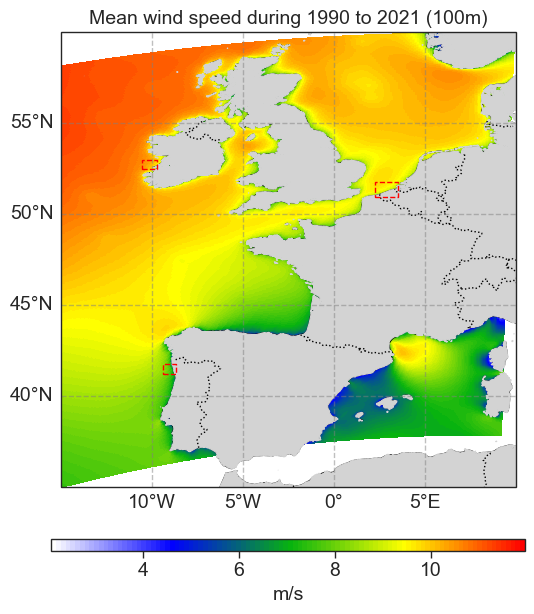

In [16]:
sns.set_theme(style="white")
sns.set_context("paper",font_scale=2)
fig = plt.figure(figsize=(6, 6), constrained_layout=True)
gs = fig.add_gridspec(1,1)
#axs = map_plotter(gs[0],mean_ws,'Mean wind speed during 1990 to 2021',0.8,'m/s',[-15, 10, 35, 60],rectangles=True)
map_plotter(gs[0,0],mean_ws,'longitude','latitude',None,cmaps.WhBlGrYeRe,
            f'Mean wind speed during 1990 to 2021 (100m)',0.8,'m/s','horizontal',extent=[-15, 10, 35, 60],rectangles=True)
plt.savefig(f'Overall_mean_wind_resources_during_1990-2021.png',dpi=300,bbox_inches='tight',pad_inches=0)

### Portugal

In [24]:
%%time
region = 'Portugal'
sample_points = all_sample_points[region]
regional_ws = regional_extraction(ws,target_grids[region]).load()

CPU times: user 2.49 s, sys: 1.48 s, total: 3.97 s
Wall time: 4.2 s


In [25]:
%%time
regional_wpd = WPD(regional_ws)
tp = turbine_power(regional_ws, turbine_type=turbine_type)
CF = tp*1e2/(rated_power*1e3) # in %
regional_mean_ws = regional_ws.mean(dim='time').load()
mean_wpd = regional_wpd.mean(dim='time').load()
mean_AEP = tp.isel(time=slice(None,-1)).resample(time='Y').sum().mean(dim='time').compute()
mean_CF = CF.mean(dim='time').compute()

CPU times: user 17.6 s, sys: 14.3 s, total: 31.9 s
Wall time: 27.2 s


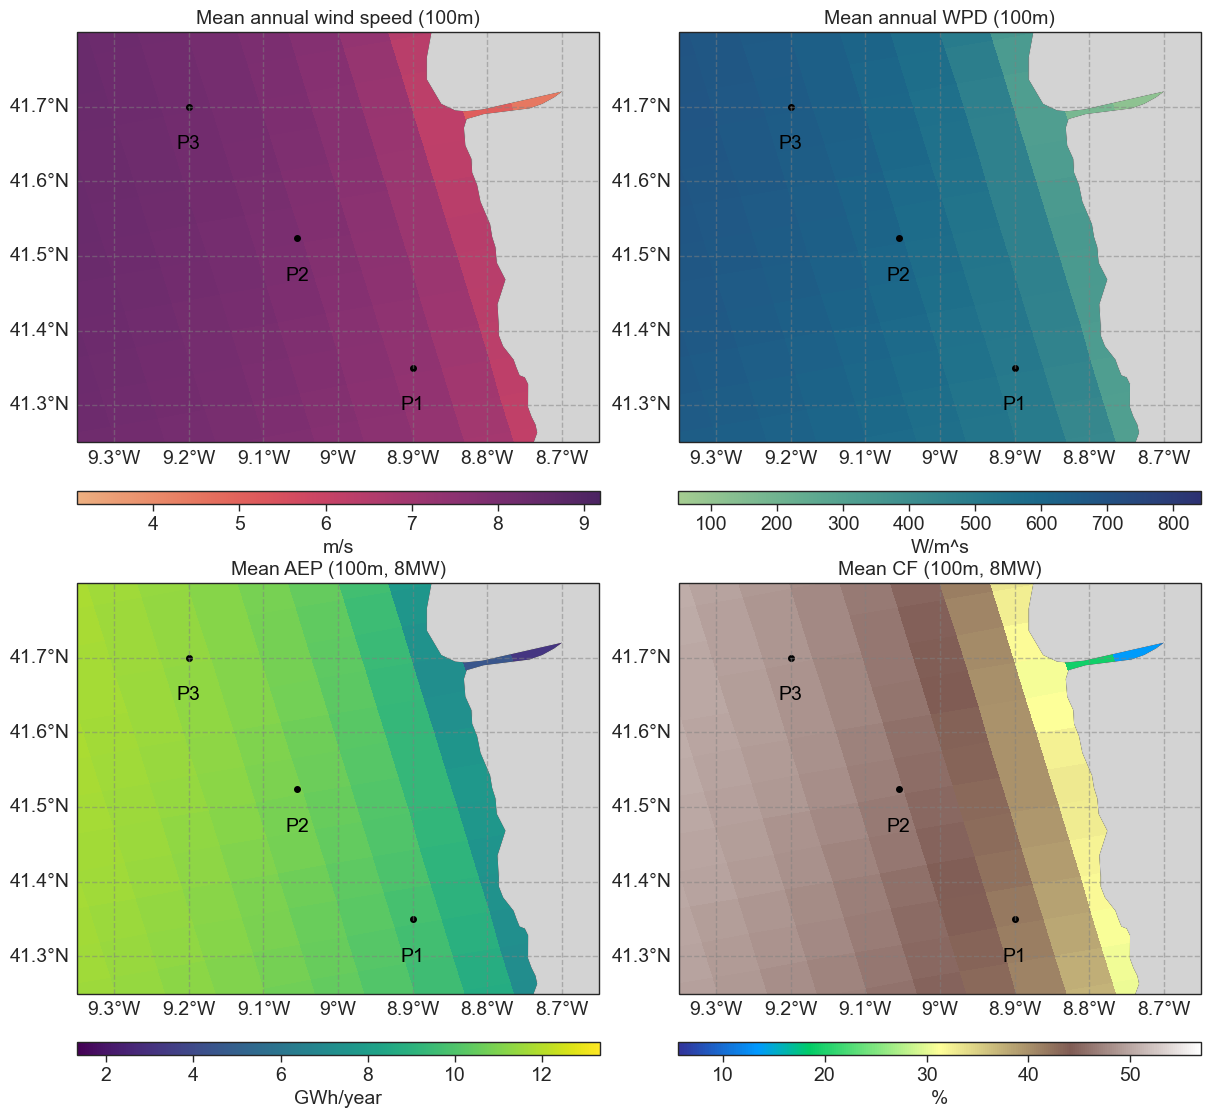

In [40]:
fig = plt.figure(figsize=(12, 11), constrained_layout=True)
gs = fig.add_gridspec(2,2)
extent=[target_grids[region]['min_lon'],target_grids[region]['max_lon'],target_grids[region]['min_lat'],target_grids[region]['max_lat']]
map_plotter(gs[0,0],regional_mean_ws,'longitude','latitude',None,'flare',
            f'Mean annual wind speed ({level}m)',1,'m/s','horizontal',sample_points = sample_points,extent=extent)
map_plotter(gs[0,1],mean_wpd,'longitude','latitude',None,'crest',
            f'Mean annual WPD ({level}m)',1,'W/m^s','horizontal',sample_points = sample_points,extent=extent)
map_plotter(gs[1,0],mean_AEP/1e6,'longitude','latitude',None,"viridis",f'Mean AEP ({level}m, {turbine_type})',1,'GWh/year','horizontal',sample_points = sample_points,extent=extent)
map_plotter(gs[1,1],mean_CF,'longitude','latitude',None,"terrain",f'Mean CF ({level}m, {turbine_type})',1,'%','horizontal',sample_points = sample_points,extent=extent)
plt.savefig(f'CERRA_mean_wind_resources_{region}_{level}m_{turbine_type}.png',dpi=300,bbox_inches='tight',pad_inches=0)

Time elapsed for nearest point identification is 0.0024461746215820312s
{'y': 17, 'x': 27}
Time elapsed for nearest point identification is 0.0010607242584228516s
{'y': 21, 'x': 25}
Time elapsed for nearest point identification is 0.0012195110321044922s
{'y': 25, 'x': 24}
Time elapsed for nearest point identification is 0.0011570453643798828s
{'y': 17, 'x': 27}
Time elapsed for nearest point identification is 0.0011150836944580078s
{'y': 21, 'x': 25}
Time elapsed for nearest point identification is 0.0012271404266357422s
{'y': 25, 'x': 24}
Time elapsed for nearest point identification is 0.0012576580047607422s
{'y': 17, 'x': 27}
Time elapsed for nearest point identification is 0.0011594295501708984s
{'y': 21, 'x': 25}
Time elapsed for nearest point identification is 0.0011692047119140625s
{'y': 25, 'x': 24}
CPU times: user 5.5 s, sys: 1.14 s, total: 6.64 s
Wall time: 4.16 s


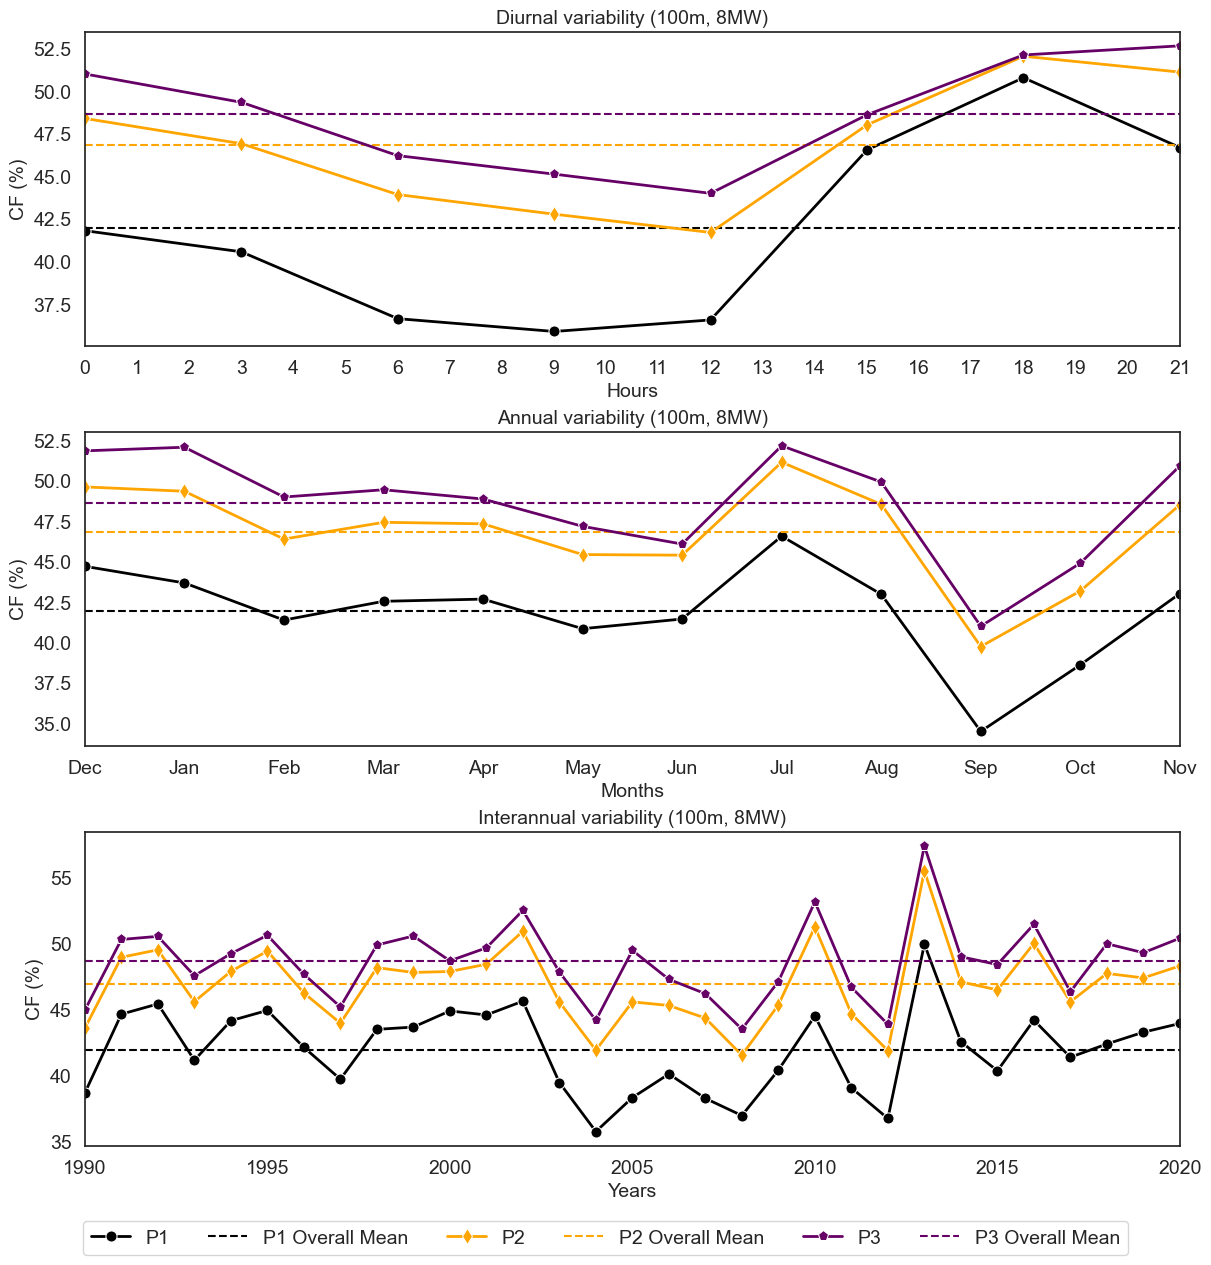

In [93]:
%%time
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(3,1)
sns.set_theme(style="white")

hourly_df = pd.DataFrame()
for i,key in enumerate(sample_points.keys()):
    ds = read_pointwise_timeseries(CF,sample_points[key][0],sample_points[key][1])

    pointwise_df = pd.DataFrame()

    # Loop through hours
    for hour in range(0,22):
        # Extract data for the current year
        data = ds.sel(time=ds.time.dt.hour == hour).mean().values
        # Create a new DataFrame with the year as a column
        #df = pd.DataFrame({'Hour': [hour], key: data})
        df = pd.DataFrame({key: data}, index=pd.Index([hour], name='Hour'))
        # Append the data to the main DataFrame
        pointwise_df = pd.concat([pointwise_df, df])
    hourly_df = pd.concat([hourly_df, pointwise_df],axis=1)

variability_plotter(gs[0,0],hourly_df,f'Diurnal variability ({level}m, {turbine_type})','Hours','CF (%)', key,colors[i],'o',xlabel_ticks=hours)


monthly_df = pd.DataFrame()
for i,key in enumerate(sample_points.keys()):
    ds = read_pointwise_timeseries(CF,sample_points[key][0],sample_points[key][1])

    pointwise_df = pd.DataFrame()

    # Loop through hours
    for month in [12,1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]:
        # Extract data for the current year
        data = ds.sel(time=ds.time.dt.month == month).mean().values
        # Create a new DataFrame with the year as a column
        #df = pd.DataFrame({'Hour': [hour], key: data})
        df = pd.DataFrame({key: data}, index=pd.Index([months[month-1]], name='month'))
        # Append the data to the main DataFrame
        pointwise_df = pd.concat([pointwise_df, df])
    monthly_df = pd.concat([monthly_df, pointwise_df],axis=1)

variability_plotter(gs[1,0],monthly_df,f'Annual variability ({level}m, {turbine_type})','Months','CF (%)', key,colors[i],'o',xlabel_ticks=months)

yearly_df = pd.DataFrame()
for i,key in enumerate(sample_points.keys()):
    ds = read_pointwise_timeseries(CF,sample_points[key][0],sample_points[key][1])

    pointwise_df = pd.DataFrame()

    # Loop through hours
    for year in list(range(1990, 2021)):
        # Extract data for the current year
        data = ds.sel(time=ds.time.dt.year == year).mean().values
        # Create a new DataFrame with the year as a column
        #df = pd.DataFrame({'Hour': [hour], key: data})
        df = pd.DataFrame({key: data}, index=pd.Index([year], name='year'))
        # Append the data to the main DataFrame
        pointwise_df = pd.concat([pointwise_df, df])
    yearly_df = pd.concat([yearly_df, pointwise_df],axis=1)

axs = variability_plotter(gs[2,0],yearly_df,f'Interannual variability ({level}m, {turbine_type})','Years','CF (%)', key,colors[i],'o')

# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.05),fontsize=14)

plt.savefig(f'CERRA_wind_resources_variabilities_{region}_{level}m_{turbine_type}.png',dpi=300,bbox_inches='tight',pad_inches=0)

In [88]:
monthly_df

,P1,P2,P3
month,,,
Dec,44.699500,49.615818,51.849138
Jan,43.669758,49.347852,52.072545
Feb,41.370992,46.386324,48.990575
Mar,42.533987,47.424739,49.439660
Apr,42.669040,47.331435,48.866490
May,40.836414,45.427367,47.175283
Jun,41.438028,45.388514,46.077712
Jul,46.565582,51.145323,52.162575
Aug,42.968997,48.536333,49.920229


### Ireland

In [21]:
region = 'Ireland'
sample_points = all_sample_points[region]
level = 100
rated_power = 8
turbine_type = f'{rated_power}MW'


In [ ]:
%%time
regional_ws = regional_extraction(ws,target_grids[region]).load()
regional_wpd = WPD(regional_ws)
tp = turbine_power(regional_ws, turbine_type=turbine_type)
CF = tp*1e2/(rated_power*1e3) # in %
regional_mean_ws = regional_ws.mean(dim='time').load()
mean_wpd = regional_wpd.mean(dim='time').load()
mean_AEP = tp.isel(time=slice(None,-1)).resample(time='Y').sum().mean(dim='time').compute()
mean_CF = mean_AEP*1e2/()

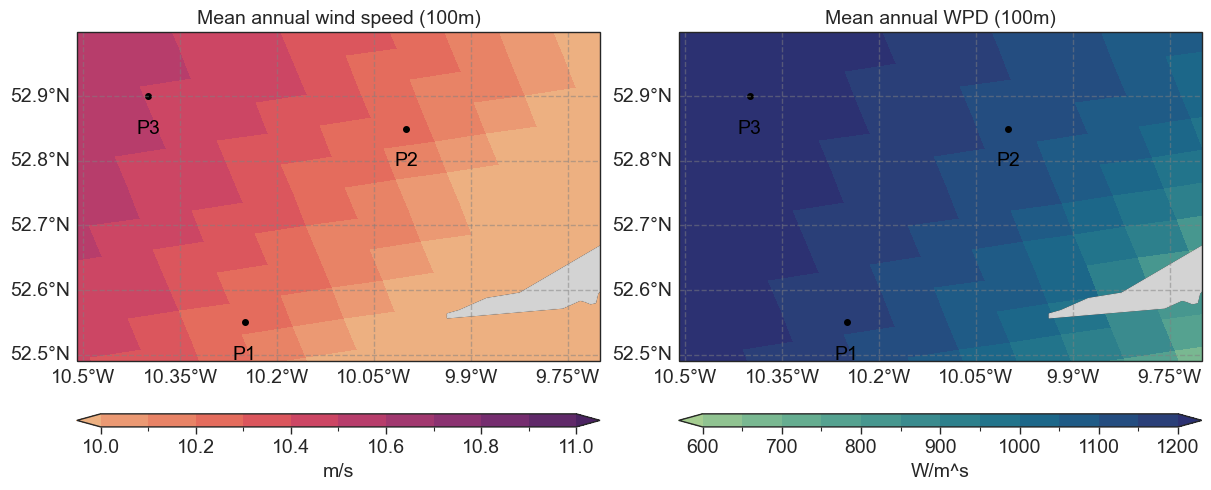

In [79]:
sns.set_theme(style="white")
sns.set_context("paper",font_scale=2)
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
gs = fig.add_gridspec(1,2)
extent=[target_grids[region]['min_lon'],target_grids[region]['max_lon'],target_grids[region]['min_lat'],target_grids[region]['max_lat']]
map_plotter(gs[0,0],mean_ws,'longitude','latitude',np.arange(10,11.1,0.1),'flare',
            f'Mean annual wind speed ({level}m)',1,'m/s','horizontal',sample_points=sample_points,extent=extent)
map_plotter(gs[0,1],mean_wpd,'longitude','latitude',np.arange(600,1200.1,50),'crest',
            f'Mean annual WPD ({level}m)',1,'W/m^s','horizontal',sample_points=sample_points,extent=extent)
plt.savefig(f'CERRA_mean_wind_resources_{region}.png',dpi=300,bbox_inches='tight',pad_inches=0)

In [41]:
%%time
regional_ws = regional_extraction(ws,target_grids[region]).load()
regional_wpd = WPD(regional_ws)

CPU times: user 2.04 s, sys: 284 ms, total: 2.33 s
Wall time: 2.7 s


Time elapsed for nearest point identification is 0.0027341842651367188s
{'y': 1, 'x': 4}
Time elapsed for nearest point identification is 0.0010657310485839844s
{'y': 6, 'x': 8}
Time elapsed for nearest point identification is 0.0010530948638916016s
{'y': 7, 'x': 3}
Time elapsed for nearest point identification is 0.0011317729949951172s
{'y': 1, 'x': 4}
Time elapsed for nearest point identification is 0.001056671142578125s
{'y': 6, 'x': 8}
Time elapsed for nearest point identification is 0.000990152359008789s
{'y': 7, 'x': 3}
Time elapsed for nearest point identification is 0.001142740249633789s
{'y': 1, 'x': 4}
Time elapsed for nearest point identification is 0.0010745525360107422s
{'y': 6, 'x': 8}
Time elapsed for nearest point identification is 0.001434326171875s
{'y': 7, 'x': 3}


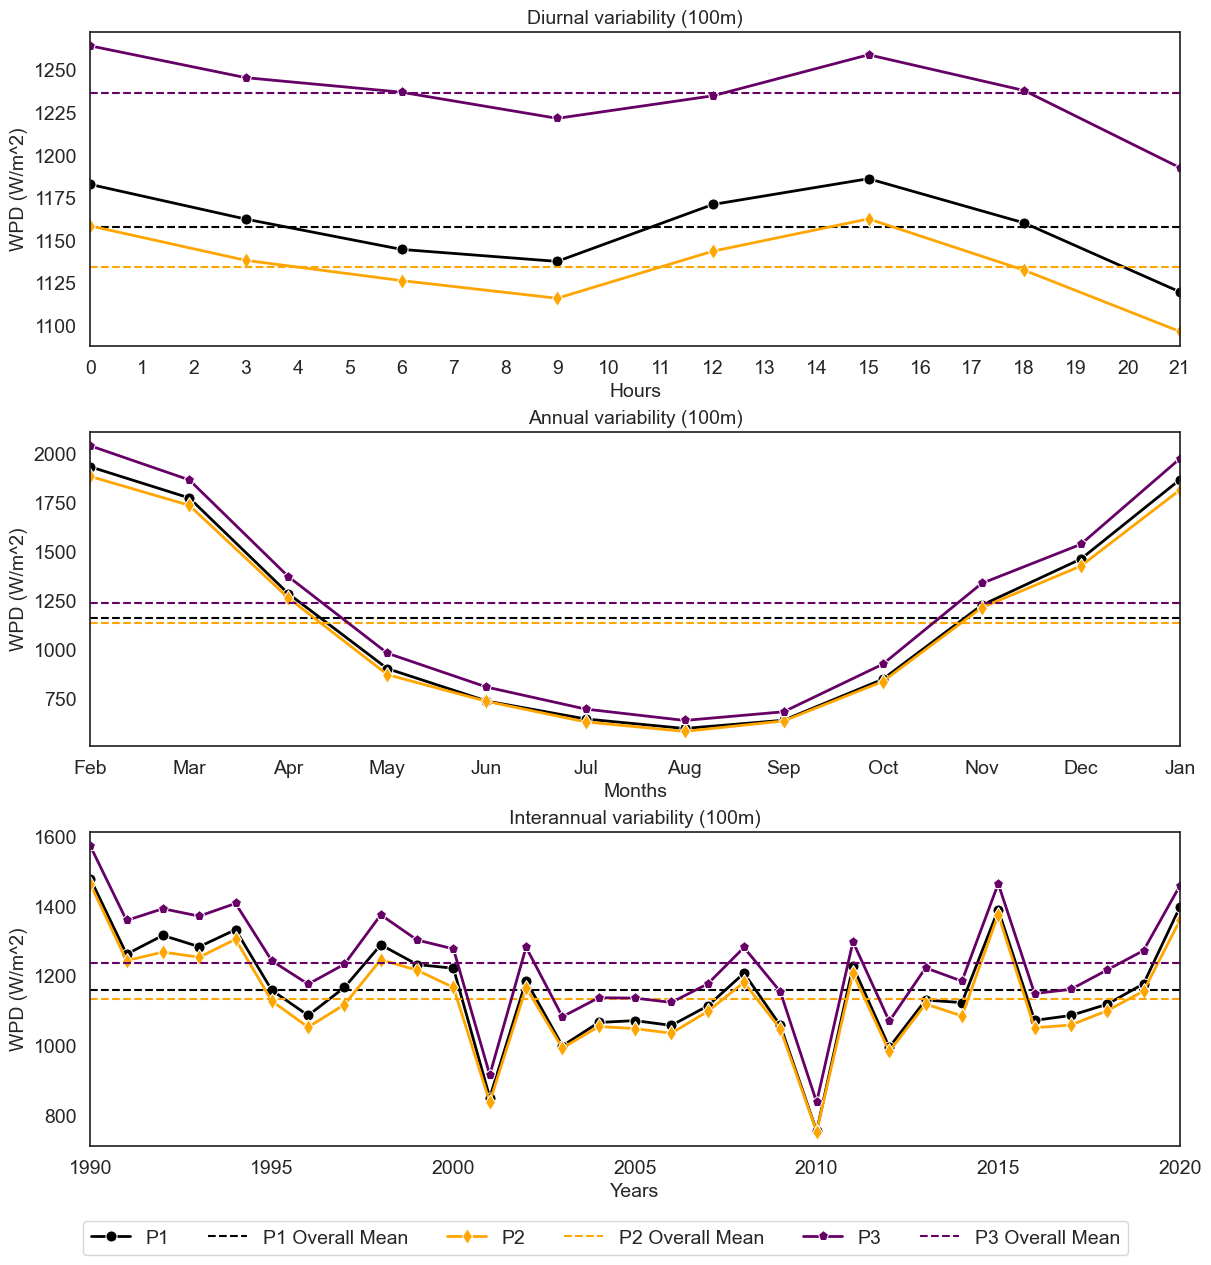

In [42]:
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(3,1)
sns.set_theme(style="white")

hourly_df = pd.DataFrame()
for i,key in enumerate(sample_points.keys()):
    ds = read_pointwise_timeseries(regional_wpd,sample_points[key][0],sample_points[key][1])

    pointwise_df = pd.DataFrame()

    # Loop through hours
    for hour in range(0,22):
        # Extract data for the current year
        data = ds.sel(time=ds.time.dt.hour == hour).mean().values
        # Create a new DataFrame with the year as a column
        #df = pd.DataFrame({'Hour': [hour], key: data})
        df = pd.DataFrame({key: data}, index=pd.Index([hour], name='Hour'))
        # Append the data to the main DataFrame
        pointwise_df = pd.concat([pointwise_df, df])
    hourly_df = pd.concat([hourly_df, pointwise_df],axis=1)

variability_plotter(gs[0,0],hourly_df,f'Diurnal variability ({level}m)','Hours','WPD (W/m^2)', key,colors[i],'o',xlabel_ticks=hours)


monthly_df = pd.DataFrame()
for i,key in enumerate(sample_points.keys()):
    ds = read_pointwise_timeseries(regional_wpd,sample_points[key][0],sample_points[key][1])

    pointwise_df = pd.DataFrame()

    # Loop through hours
    for month in [12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]:
        # Extract data for the current year
        data = ds.sel(time=ds.time.dt.month == month).mean().values
        # Create a new DataFrame with the year as a column
        #df = pd.DataFrame({'Hour': [hour], key: data})
        df = pd.DataFrame({key: data}, index=pd.Index([month], name='month'))
        # Append the data to the main DataFrame
        pointwise_df = pd.concat([pointwise_df, df])
    monthly_df = pd.concat([monthly_df, pointwise_df],axis=1)

variability_plotter(gs[1,0],monthly_df,f'Annual variability ({level}m)','Months','WPD (W/m^2)', key,colors[i],'o',xlabel_ticks=months)

yearly_df = pd.DataFrame()
for i,key in enumerate(sample_points.keys()):
    ds = read_pointwise_timeseries(regional_wpd,sample_points[key][0],sample_points[key][1])

    pointwise_df = pd.DataFrame()

    # Loop through hours
    for year in list(range(1990, 2021)):
        # Extract data for the current year
        data = ds.sel(time=ds.time.dt.year == year).mean().values
        # Create a new DataFrame with the year as a column
        #df = pd.DataFrame({'Hour': [hour], key: data})
        df = pd.DataFrame({key: data}, index=pd.Index([year], name='year'))
        # Append the data to the main DataFrame
        pointwise_df = pd.concat([pointwise_df, df])
    yearly_df = pd.concat([yearly_df, pointwise_df],axis=1)

axs = variability_plotter(gs[2,0],yearly_df,f'Interannual variability ({level}m)','Years','WPD (W/m^2)', key,colors[i],'o')

# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.05),fontsize=14)

plt.savefig(f'CERRA_wind_resources_variabilities_{region}.png',dpi=300,bbox_inches='tight',pad_inches=0)

### BeNeLux

In [76]:
region = 'BeNeLux'
sample_points = {
    "P1": (51.3, 2.3),
    "P2": (51.6, 2.6), #P2 is POR2 in tslist
    "P3": (51.75, 3.25),
}

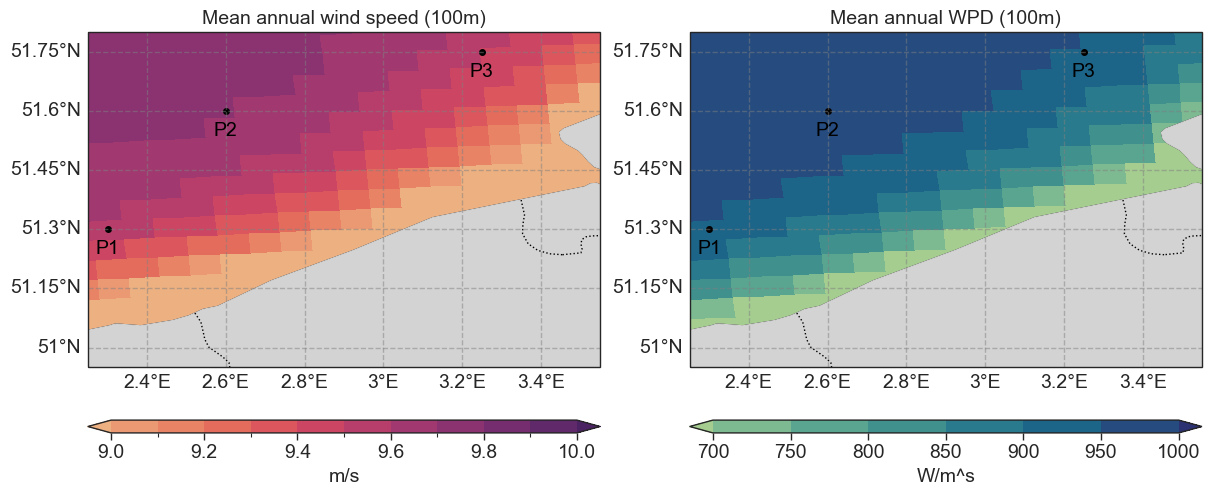

In [77]:
sns.set_theme(style="white")
sns.set_context("paper",font_scale=2)
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
gs = fig.add_gridspec(1,2)
extent=[target_grids[region]['min_lon'],target_grids[region]['max_lon'],target_grids[region]['min_lat'],target_grids[region]['max_lat']]
map_plotter(gs[0,0],mean_ws,'longitude','latitude',np.arange(9,10.1,0.1),'flare',
            f'Mean annual wind speed ({level}m)',1,'m/s','horizontal',sample_points=sample_points,extent=extent)
map_plotter(gs[0,1],mean_wpd,'longitude','latitude',np.arange(700,1000.1,50),'crest',
            f'Mean annual WPD ({level}m)',1,'W/m^s','horizontal',sample_points=sample_points,extent=extent)
plt.savefig(f'CERRA_mean_wind_resources_{region}.png',dpi=300,bbox_inches='tight',pad_inches=0)

In [46]:
%%time
regional_ws = regional_extraction(ws,target_grids[region]).load()
regional_wpd = WPD(regional_ws)

CPU times: user 2.3 s, sys: 619 ms, total: 2.92 s
Wall time: 3.15 s


Time elapsed for nearest point identification is 0.001996755599975586s
{'y': 7, 'x': 1}
Time elapsed for nearest point identification is 0.0011355876922607422s
{'y': 13, 'x': 5}
Time elapsed for nearest point identification is 0.0012204647064208984s
{'y': 15, 'x': 14}
Time elapsed for nearest point identification is 0.0013706684112548828s
{'y': 7, 'x': 1}
Time elapsed for nearest point identification is 0.0010838508605957031s
{'y': 13, 'x': 5}
Time elapsed for nearest point identification is 0.0010783672332763672s
{'y': 15, 'x': 14}
Time elapsed for nearest point identification is 0.001165151596069336s
{'y': 7, 'x': 1}
Time elapsed for nearest point identification is 0.0011534690856933594s
{'y': 13, 'x': 5}
Time elapsed for nearest point identification is 0.0012423992156982422s
{'y': 15, 'x': 14}


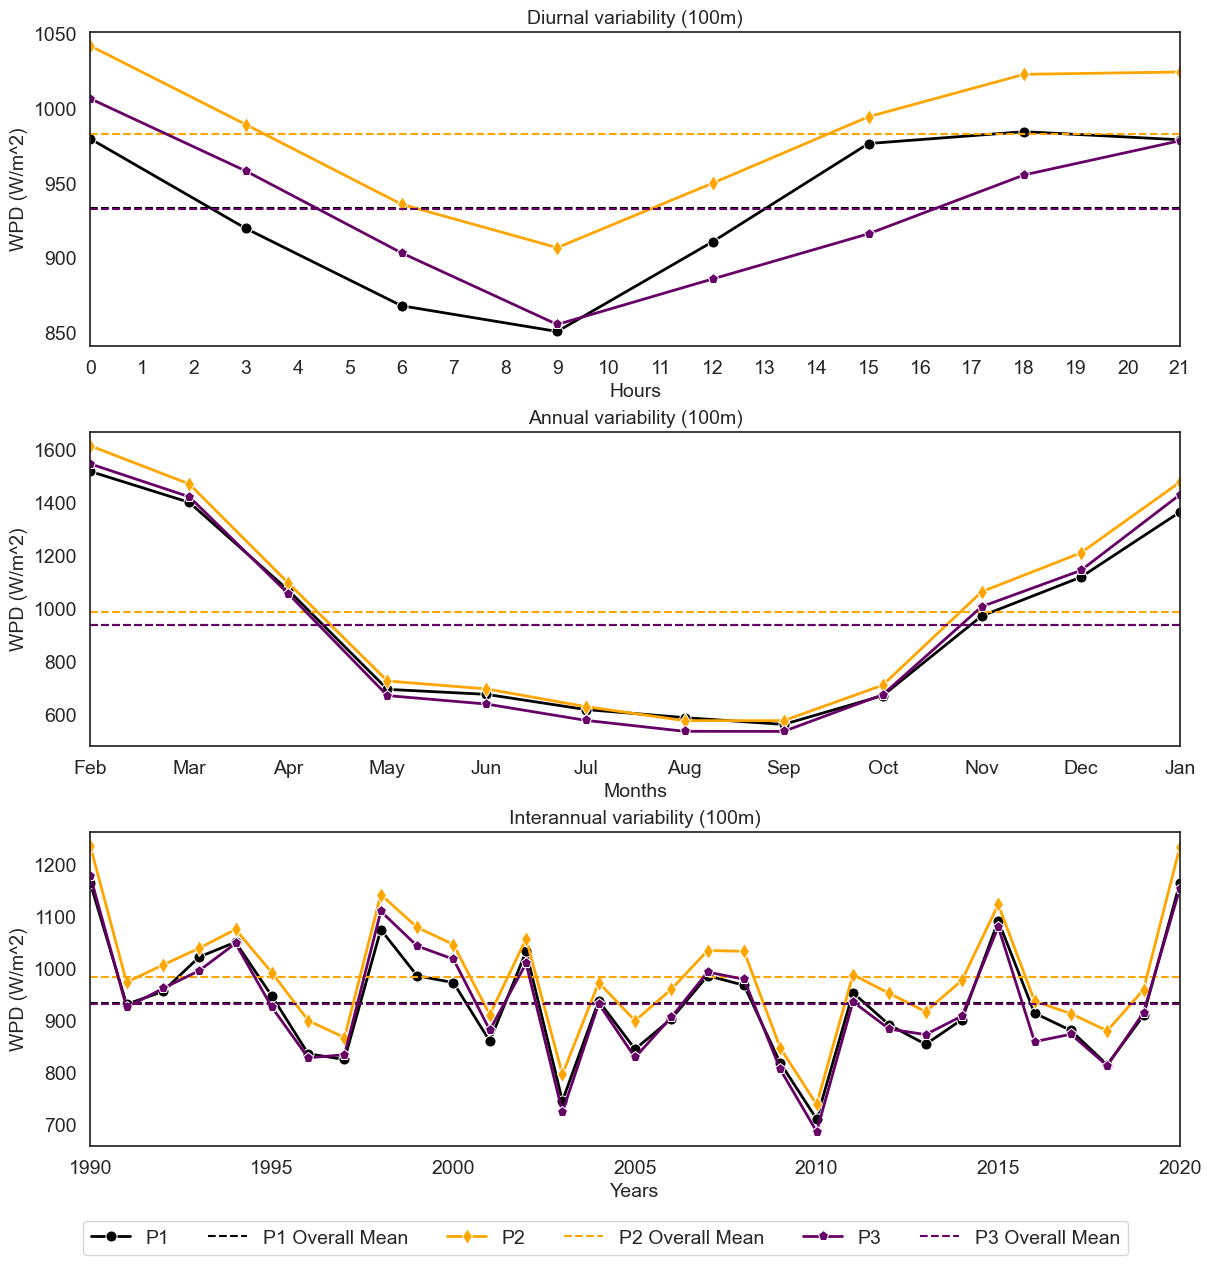

In [47]:
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(3,1)
sns.set_theme(style="white")

hourly_df = pd.DataFrame()
for i,key in enumerate(sample_points.keys()):
    ds = read_pointwise_timeseries(regional_wpd,sample_points[key][0],sample_points[key][1])

    pointwise_df = pd.DataFrame()

    # Loop through hours
    for hour in range(0,22):
        # Extract data for the current year
        data = ds.sel(time=ds.time.dt.hour == hour).mean().values
        # Create a new DataFrame with the year as a column
        #df = pd.DataFrame({'Hour': [hour], key: data})
        df = pd.DataFrame({key: data}, index=pd.Index([hour], name='Hour'))
        # Append the data to the main DataFrame
        pointwise_df = pd.concat([pointwise_df, df])
    hourly_df = pd.concat([hourly_df, pointwise_df],axis=1)

variability_plotter(gs[0,0],hourly_df,f'Diurnal variability ({level}m)','Hours','WPD (W/m^2)', key,colors[i],'o',xlabel_ticks=hours)


monthly_df = pd.DataFrame()
for i,key in enumerate(sample_points.keys()):
    ds = read_pointwise_timeseries(regional_wpd,sample_points[key][0],sample_points[key][1])

    pointwise_df = pd.DataFrame()

    # Loop through hours
    for month in [12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]:
        # Extract data for the current year
        data = ds.sel(time=ds.time.dt.month == month).mean().values
        # Create a new DataFrame with the year as a column
        #df = pd.DataFrame({'Hour': [hour], key: data})
        df = pd.DataFrame({key: data}, index=pd.Index([month], name='month'))
        # Append the data to the main DataFrame
        pointwise_df = pd.concat([pointwise_df, df])
    monthly_df = pd.concat([monthly_df, pointwise_df],axis=1)

variability_plotter(gs[1,0],monthly_df,f'Annual variability ({level}m)','Months','WPD (W/m^2)', key,colors[i],'o',xlabel_ticks=months)

yearly_df = pd.DataFrame()
for i,key in enumerate(sample_points.keys()):
    ds = read_pointwise_timeseries(regional_wpd,sample_points[key][0],sample_points[key][1])

    pointwise_df = pd.DataFrame()

    # Loop through hours
    for year in list(range(1990, 2021)):
        # Extract data for the current year
        data = ds.sel(time=ds.time.dt.year == year).mean().values
        # Create a new DataFrame with the year as a column
        #df = pd.DataFrame({'Hour': [hour], key: data})
        df = pd.DataFrame({key: data}, index=pd.Index([year], name='year'))
        # Append the data to the main DataFrame
        pointwise_df = pd.concat([pointwise_df, df])
    yearly_df = pd.concat([yearly_df, pointwise_df],axis=1)

axs = variability_plotter(gs[2,0],yearly_df,f'Interannual variability ({level}m)','Years','WPD (W/m^2)', key,colors[i],'o')

# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.05),fontsize=14)

plt.savefig(f'CERRA_wind_resources_variabilities_{region}.png',dpi=300,bbox_inches='tight',pad_inches=0)

## Solar Resource Assessment
- One thing to note here is that the surface solar radiation downwards is an accumulated parameter, accumulated from last analysis.
- The variable is in $J/m^2$. To convert it into $W/m^2$, divide it by 3600
- https://confluence.ecmwf.int/pages/viewpage.action?pageId=155337784

In [53]:
Epv = 0.216
cell_watt = 365

In [67]:
%%time
files = sorted(glob.glob(f'{root_dir}/ws10/CERRA_*.nc'))
chunks={"time": 96,"x": -1,"y": -1}
ds = xr.open_mfdataset(files,chunks=chunks,concat_dim='time',combine='nested',parallel=True)
ws10 = ds['__xarray_dataarray_variable__'].sel(time=slice('1990-01-01T00','2021-01-01T00'))

files = sorted(glob.glob(f'{root_dir}/t2m/CERRA_*.nc'))
chunks={"time": 96,"x": -1,"y": -1}
ds = xr.open_mfdataset(files,chunks=chunks,concat_dim='time',combine='nested',parallel=True)
t2m = ds['t2m'].sel(time=slice('1990-01-01T00','2021-01-01T00'))-273.16

files = sorted(glob.glob(f'{root_dir}/swdown/CERRA_*.nc'))
chunks={"time": 96,"x": -1,"y": -1}
ds = xr.open_mfdataset(files,chunks=chunks,concat_dim='time',combine='nested',parallel=True)
swdown = ds['ssrd'].sel(time=slice('1990-01-01T00','2021-01-01T00'))/3600

CPU times: user 4.21 s, sys: 932 ms, total: 5.14 s
Wall time: 4.27 s


In [69]:
%%time
# getting overall mean wind speed
mean_ws10 = ws10.mean(dim='time').load()
mean_t2m = t2m.mean(dim='time').load()
mean_swdown = swdown.mean(dim='time').load()

CPU times: user 2min 24s, sys: 0 ns, total: 2min 24s
Wall time: 5min 55s


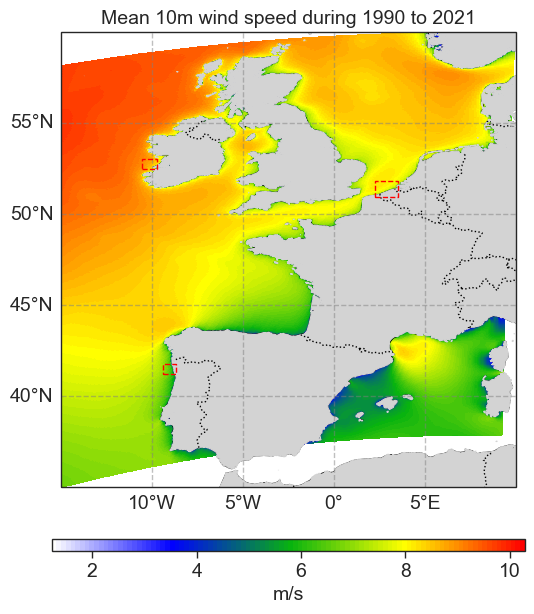

In [70]:
sns.set_theme(style="white")
sns.set_context("paper",font_scale=2)
fig = plt.figure(figsize=(6, 6), constrained_layout=True)
gs = fig.add_gridspec(1,1)
map_plotter(gs[0,0],mean_ws10,'longitude','latitude',None,cmaps.WhBlGrYeRe,
            f'Mean 10m wind speed during 1990 to 2021',0.8,r'm/s','horizontal',extent=[-15, 10, 35, 60],rectangles=True)
plt.savefig(f'Overall_mean_10m_wind_speed_during_1990-2021.png',dpi=300,bbox_inches='tight',pad_inches=0)

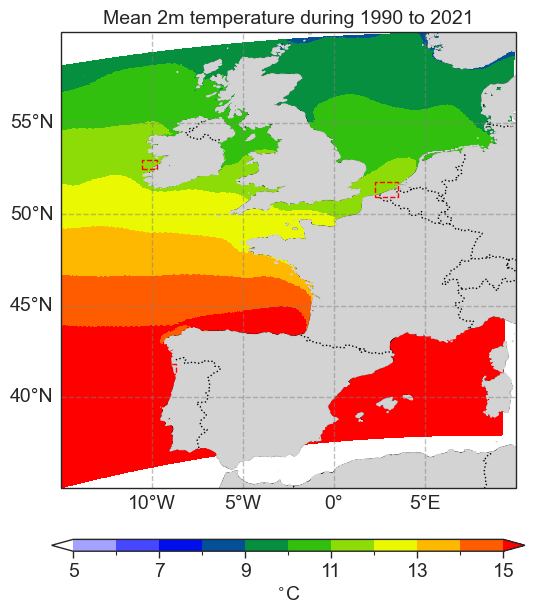

In [44]:
sns.set_theme(style="white")
sns.set_context("paper",font_scale=2)
fig = plt.figure(figsize=(6, 6), constrained_layout=True)
gs = fig.add_gridspec(1,1)
map_plotter(gs[0,0],mean_t2m,'longitude','latitude',np.arange(5,15.1,1),cmaps.WhBlGrYeRe,
            f'Mean 2m temperature during 1990 to 2021',0.8,r'$^{\circ}$C','horizontal',extent=[-15, 10, 35, 60],rectangles=True)
plt.savefig(f'Overall_mean_surface_air_temperature_during_1990-2021.png',dpi=300,bbox_inches='tight',pad_inches=0)

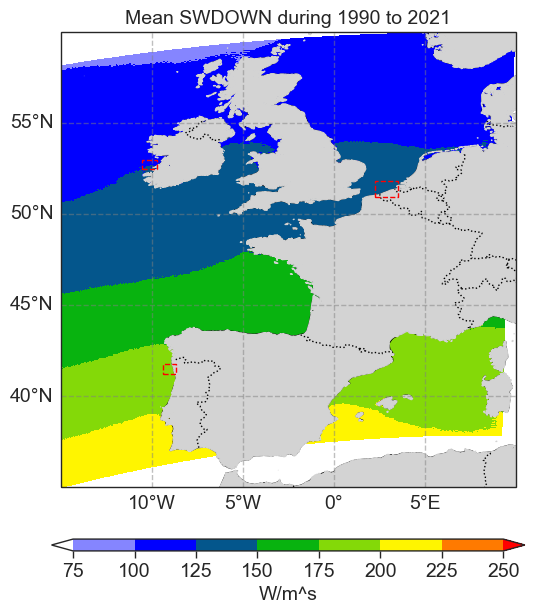

In [45]:
sns.set_theme(style="white")
sns.set_context("paper",font_scale=2)
fig = plt.figure(figsize=(6, 6), constrained_layout=True)
gs = fig.add_gridspec(1,1)
map_plotter(gs[0,0],mean_swdown,'longitude','latitude',np.arange(75,250.1,25),cmaps.WhBlGrYeRe,
            f'Mean SWDOWN during 1990 to 2021',0.8,'W/m^s','horizontal',extent=[-15, 10, 35, 60],rectangles=True)
plt.savefig(f'Overall_mean_SWDOWN_during_1990-2021.png',dpi=300,bbox_inches='tight',pad_inches=0)

### Portugal

In [71]:
%%time
region = 'Portugal'
sample_points = all_sample_points[region]
regional_ws = regional_extraction(ws10,target_grids[region]).load()
regional_t2m = regional_extraction(t2m,target_grids[region]).load()
regional_swdown = regional_extraction(swdown,target_grids[region]).load()

spv = solar_power(regional_ws, regional_swdown,regional_t2m, Epv)
spv = spv.assign_coords(latitude=regional_ws.latitude,longitude=regional_ws.longitude)

CF = spv*1e2/(cell_watt) # in %
mean_t2m = regional_t2m.mean(dim='time').compute()
mean_swdown = regional_swdown.mean(dim='time').compute()
mean_AEP = spv.isel(time=slice(None,-1)).resample(time='Y').sum().mean(dim='time').compute()
mean_CF = CF.mean(dim='time').compute()

CPU times: user 1min 50s, sys: 31.5 s, total: 2min 22s
Wall time: 4min 36s


In [91]:
spv = spv.assign_coords(latitude=regional_ws.latitude,longitude=regional_ws.longitude)

CF = spv*1e2/(cell_watt) # in %
mean_t2m = regional_t2m.mean(dim='time').compute()
mean_swdown = regional_swdown.mean(dim='time').compute()
mean_AEP = spv.isel(time=slice(None,-1)).resample(time='Y').sum().mean(dim='time').compute()
mean_CF = CF.mean(dim='time').compute()

In [97]:
mean_CF = mean_AEP*1e2/(cell_watt*2922) #Since, CERRA is having data at every 3 hours

In [100]:
all_levels = {}
all_levels['Portugal'] = {
    "t2m": np.arange(14,16.1,0.1),
    "swdown": np.arange(170,200.1,5),
    "solar_AEP": np.arange(100,130.1,2),
    "solar_CF": np.arange(10,12.1,0.1),
}

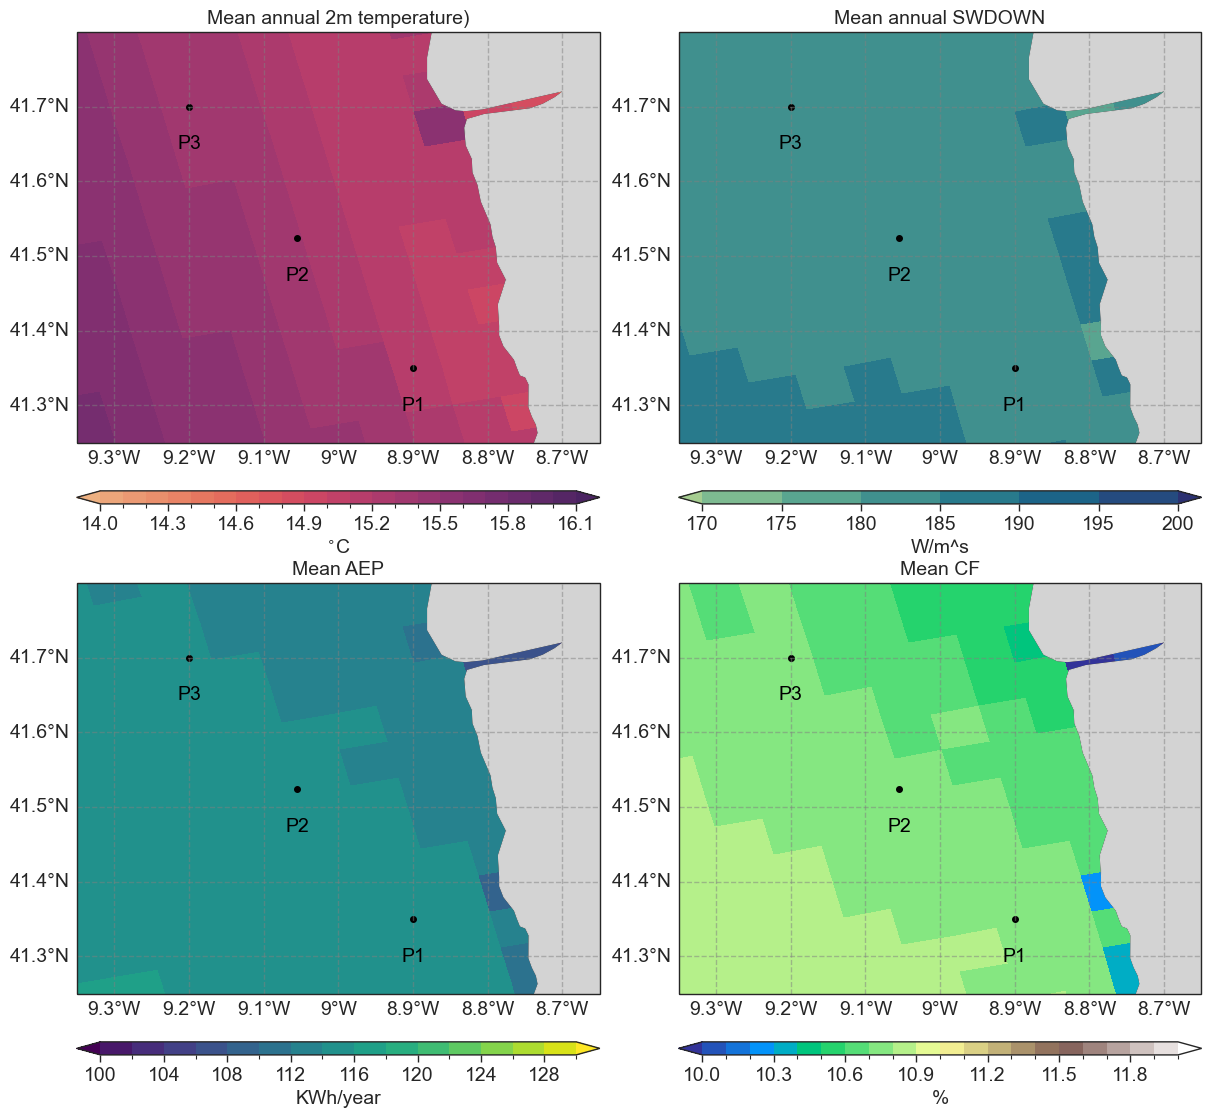

In [101]:
sns.set_theme(style="white")
sns.set_context("paper",font_scale=2)
fig = plt.figure(figsize=(12, 11), constrained_layout=True)
gs = fig.add_gridspec(2,2)
extent=[target_grids[region]['min_lon'],target_grids[region]['max_lon'],target_grids[region]['min_lat'],target_grids[region]['max_lat']]
map_plotter(gs[0,0],mean_t2m,'longitude','latitude',all_levels[region]['t2m'],'flare',
            f'Mean annual 2m temperature)',1,r'$^{\circ}$C','horizontal',sample_points = sample_points,extent=extent)
map_plotter(gs[0,1],mean_swdown,'longitude','latitude',all_levels[region]['swdown'],'crest',
            f'Mean annual SWDOWN',1,'W/m^s','horizontal',sample_points = sample_points,extent=extent)
map_plotter(gs[1,0],mean_AEP/1e3,'longitude','latitude',all_levels[region]['solar_AEP'],"viridis",f'Mean AEP',1,'KWh/year','horizontal',sample_points = sample_points,extent=extent)
map_plotter(gs[1,1],mean_CF,'longitude','latitude',all_levels[region]['solar_CF'],"terrain",f'Mean CF',1,'%','horizontal',sample_points = sample_points,extent=extent)
plt.savefig(f'CERRA_mean_solar_resources_{region}.png',dpi=300,bbox_inches='tight',pad_inches=0)

Time elapsed for nearest point identification is 0.00167083740234375s
{'y': 17, 'x': 27}
Time elapsed for nearest point identification is 0.0006625652313232422s
{'y': 21, 'x': 25}
Time elapsed for nearest point identification is 0.0005638599395751953s
{'y': 25, 'x': 24}
Time elapsed for nearest point identification is 0.0006017684936523438s
{'y': 17, 'x': 27}
Time elapsed for nearest point identification is 0.0005655288696289062s
{'y': 21, 'x': 25}
Time elapsed for nearest point identification is 0.0006086826324462891s
{'y': 25, 'x': 24}
Time elapsed for nearest point identification is 0.0006158351898193359s
{'y': 17, 'x': 27}
Time elapsed for nearest point identification is 0.0005867481231689453s
{'y': 21, 'x': 25}
Time elapsed for nearest point identification is 0.0006532669067382812s
{'y': 25, 'x': 24}
CPU times: user 4.05 s, sys: 586 ms, total: 4.64 s
Wall time: 3.37 s


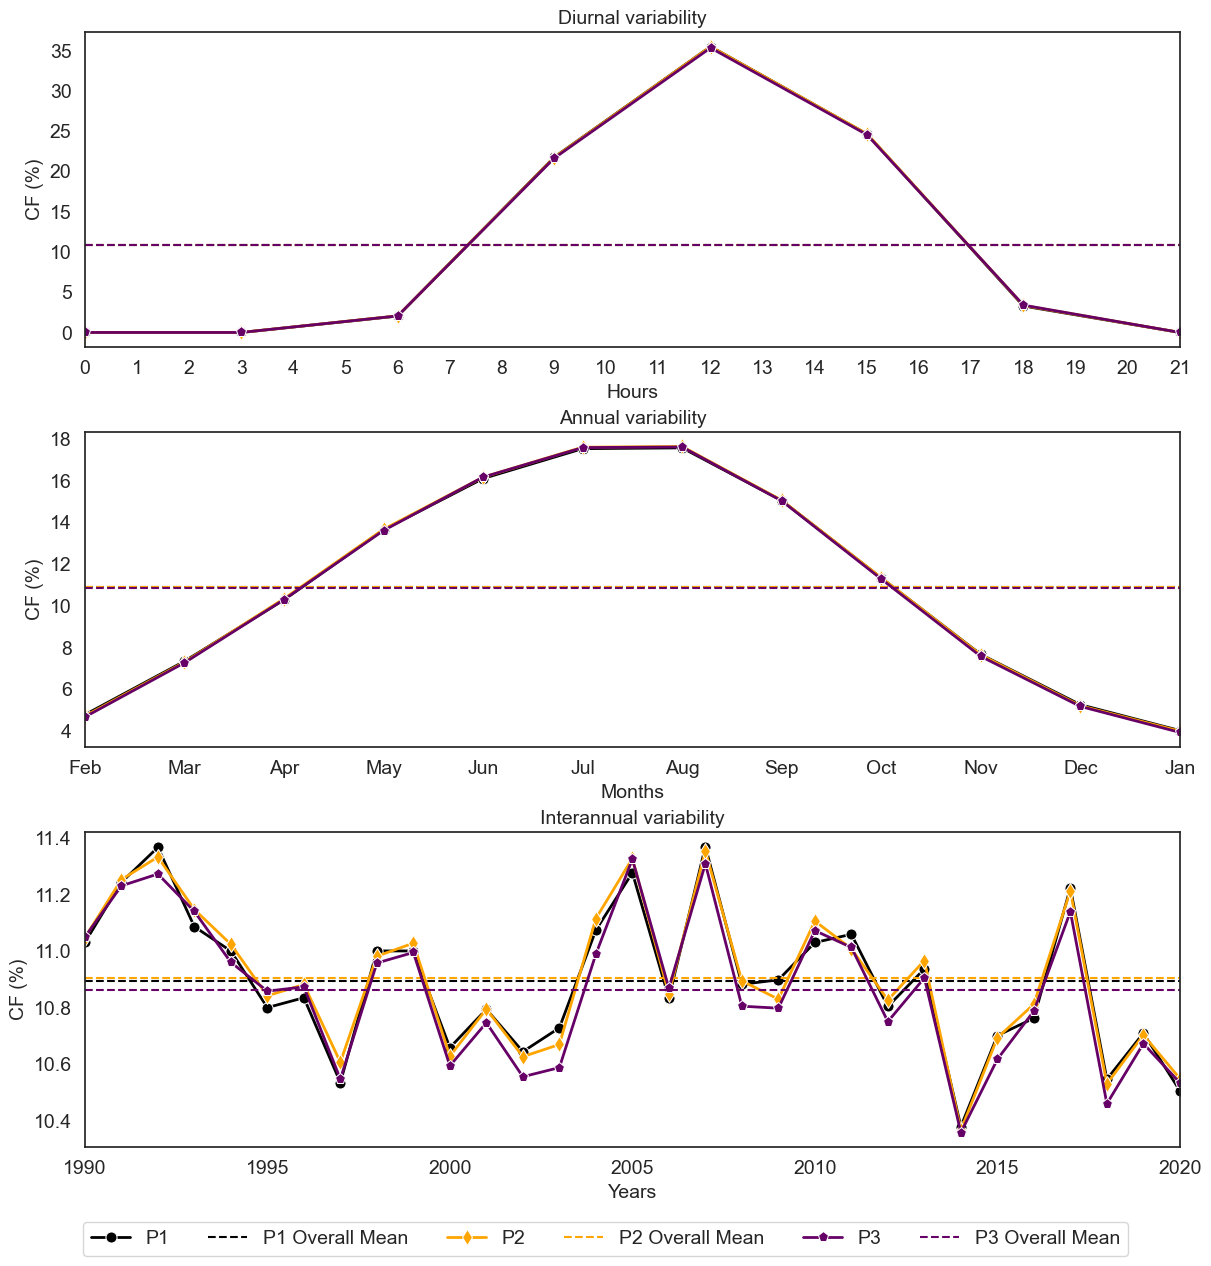

In [52]:
%%time
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(3,1)
sns.set_theme(style="white")

hourly_df = pd.DataFrame()
for i,key in enumerate(sample_points.keys()):
    ds = read_pointwise_timeseries(CF,sample_points[key][0],sample_points[key][1])

    pointwise_df = pd.DataFrame()

    # Loop through hours
    for hour in range(0,22):
        # Extract data for the current year
        data = ds.sel(time=ds.time.dt.hour == hour).mean().values
        # Create a new DataFrame with the year as a column
        #df = pd.DataFrame({'Hour': [hour], key: data})
        df = pd.DataFrame({key: data}, index=pd.Index([hour], name='Hour'))
        # Append the data to the main DataFrame
        pointwise_df = pd.concat([pointwise_df, df])
    hourly_df = pd.concat([hourly_df, pointwise_df],axis=1)

variability_plotter(gs[0,0],hourly_df,f'Diurnal variability','Hours','CF (%)', key,colors[i],'o',xlabel_ticks=hours)


monthly_df = pd.DataFrame()
for i,key in enumerate(sample_points.keys()):
    ds = read_pointwise_timeseries(CF,sample_points[key][0],sample_points[key][1])

    pointwise_df = pd.DataFrame()

    # Loop through hours
    for month in [12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]:
        # Extract data for the current year
        data = ds.sel(time=ds.time.dt.month == month).mean().values
        # Create a new DataFrame with the year as a column
        #df = pd.DataFrame({'Hour': [hour], key: data})
        df = pd.DataFrame({key: data}, index=pd.Index([month], name='month'))
        # Append the data to the main DataFrame
        pointwise_df = pd.concat([pointwise_df, df])
    monthly_df = pd.concat([monthly_df, pointwise_df],axis=1)

variability_plotter(gs[1,0],monthly_df,f'Annual variability','Months','CF (%)', key,colors[i],'o',xlabel_ticks=months)

yearly_df = pd.DataFrame()
for i,key in enumerate(sample_points.keys()):
    ds = read_pointwise_timeseries(CF,sample_points[key][0],sample_points[key][1])

    pointwise_df = pd.DataFrame()

    # Loop through hours
    for year in list(range(1990, 2021)):
        # Extract data for the current year
        data = ds.sel(time=ds.time.dt.year == year).mean().values
        # Create a new DataFrame with the year as a column
        #df = pd.DataFrame({'Hour': [hour], key: data})
        df = pd.DataFrame({key: data}, index=pd.Index([year], name='year'))
        # Append the data to the main DataFrame
        pointwise_df = pd.concat([pointwise_df, df])
    yearly_df = pd.concat([yearly_df, pointwise_df],axis=1)

axs = variability_plotter(gs[2,0],yearly_df,f'Interannual variability','Years','CF (%)', key,colors[i],'o')

# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.05),fontsize=14)

plt.savefig(f'CERRA_solar_resources_variabilities_{region}.png',dpi=300,bbox_inches='tight',pad_inches=0)

### Ireland

In [74]:
region = 'Ireland'
sample_points = {
    "P1": (52.55,-10.25),
    "P2": (52.85, -10), #P2 is POR2 in tslist
    "P3": (52.9, -10.4),
}

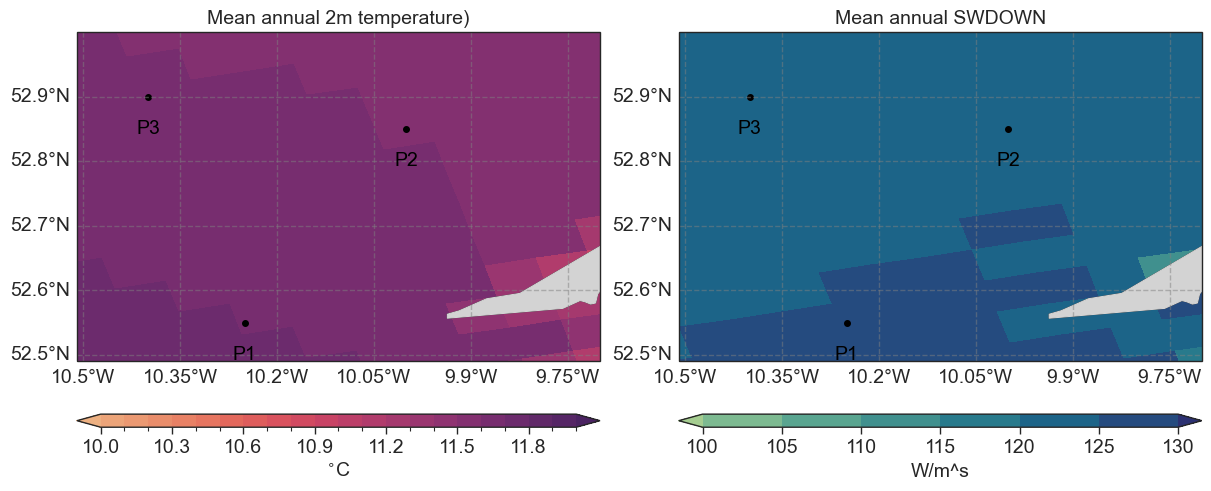

In [75]:
sns.set_theme(style="white")
sns.set_context("paper",font_scale=2)
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
gs = fig.add_gridspec(1,2)
extent=[target_grids[region]['min_lon'],target_grids[region]['max_lon'],target_grids[region]['min_lat'],target_grids[region]['max_lat']]
map_plotter(gs[0,0],mean_t2m,'longitude','latitude',np.arange(10,12.1,0.1),'flare',
            f'Mean annual 2m temperature)',1,r'$^{\circ}$C','horizontal',sample_points = sample_points,extent=extent)
map_plotter(gs[0,1],mean_swdown,'longitude','latitude',np.arange(100,130.1,5),'crest',
            f'Mean annual SWDOWN',1,'W/m^s','horizontal',sample_points = sample_points,extent=extent)
plt.savefig(f'CERRA_mean_solar_resources_{region}.png',dpi=300,bbox_inches='tight',pad_inches=0)

In [60]:
%%time
regional_t2m = regional_extraction(t2m,target_grids[region]).load()
regional_swdown = regional_extraction(swdown,target_grids[region]).load()

CPU times: user 1min 2s, sys: 9.18 s, total: 1min 11s
Wall time: 1min 55s


Time elapsed for nearest point identification is 0.003893136978149414s
{'y': 1, 'x': 4}
Time elapsed for nearest point identification is 0.0011284351348876953s
{'y': 6, 'x': 8}
Time elapsed for nearest point identification is 0.0011203289031982422s
{'y': 7, 'x': 3}
Time elapsed for nearest point identification is 0.0011627674102783203s
{'y': 1, 'x': 4}
Time elapsed for nearest point identification is 0.0011217594146728516s
{'y': 6, 'x': 8}
Time elapsed for nearest point identification is 0.0010883808135986328s
{'y': 7, 'x': 3}
Time elapsed for nearest point identification is 0.0011706352233886719s
{'y': 1, 'x': 4}
Time elapsed for nearest point identification is 0.0011096000671386719s
{'y': 6, 'x': 8}
Time elapsed for nearest point identification is 0.0011279582977294922s
{'y': 7, 'x': 3}
CPU times: user 6.13 s, sys: 1.34 s, total: 7.46 s
Wall time: 4.5 s


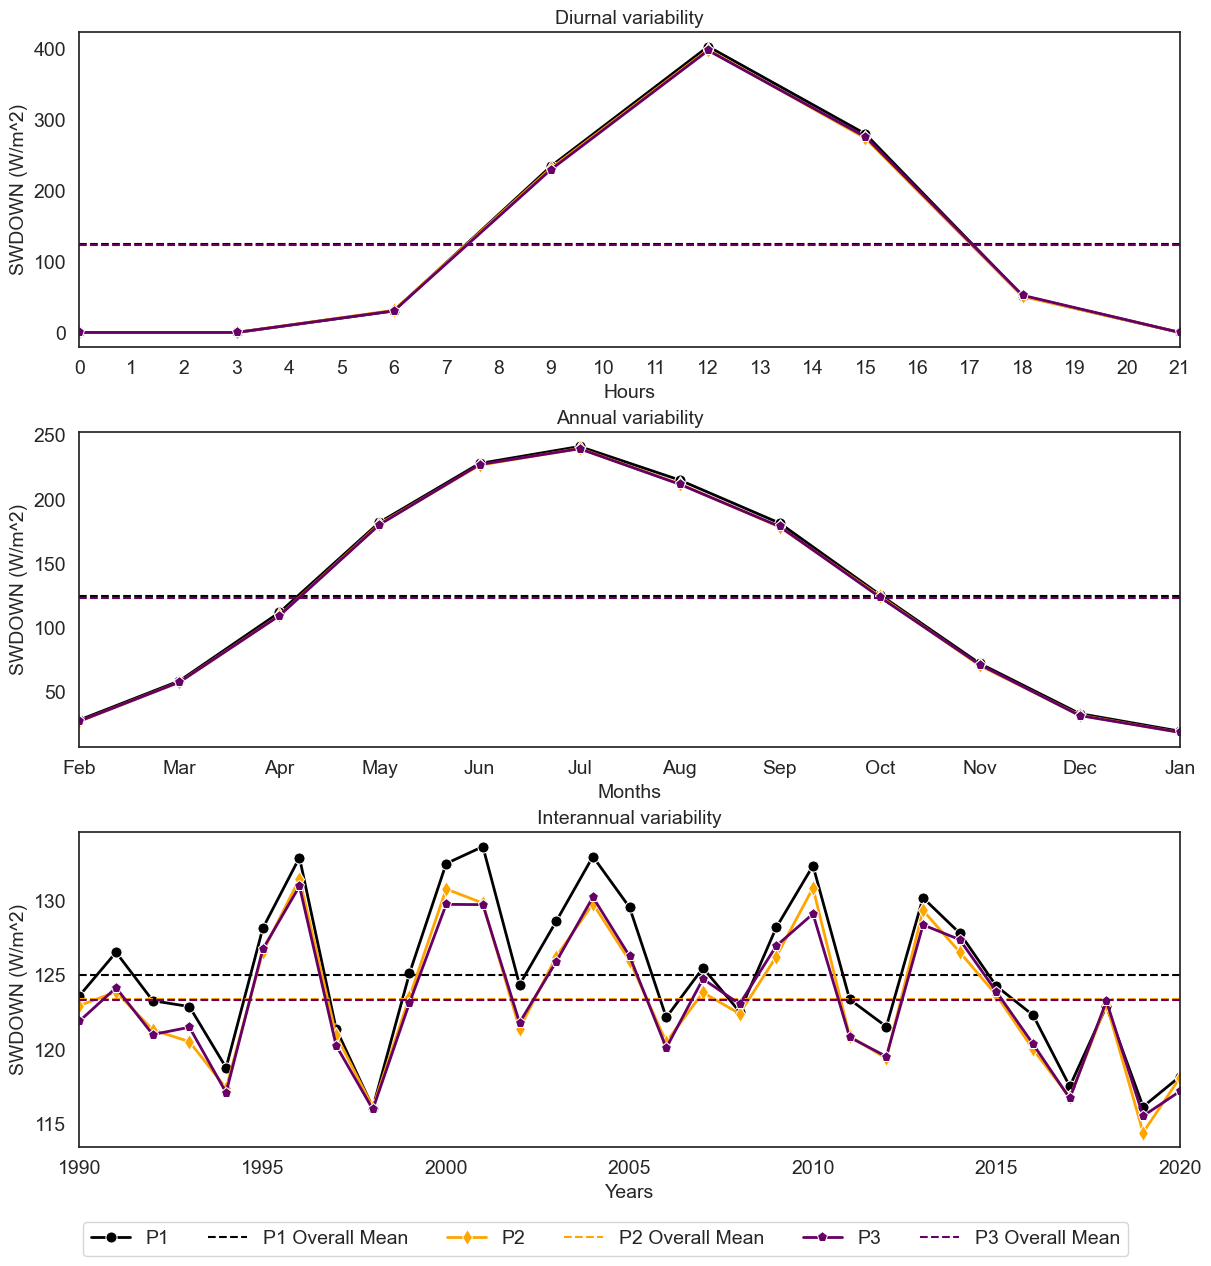

In [61]:
%%time
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(3,1)
sns.set_theme(style="white")

hourly_df = pd.DataFrame()
for i,key in enumerate(sample_points.keys()):
    ds = read_pointwise_timeseries(regional_swdown,sample_points[key][0],sample_points[key][1])

    pointwise_df = pd.DataFrame()

    # Loop through hours
    for hour in range(0,22):
        # Extract data for the current year
        data = ds.sel(time=ds.time.dt.hour == hour).mean().values
        # Create a new DataFrame with the year as a column
        #df = pd.DataFrame({'Hour': [hour], key: data})
        df = pd.DataFrame({key: data}, index=pd.Index([hour], name='Hour'))
        # Append the data to the main DataFrame
        pointwise_df = pd.concat([pointwise_df, df])
    hourly_df = pd.concat([hourly_df, pointwise_df],axis=1)

variability_plotter(gs[0,0],hourly_df,f'Diurnal variability','Hours','SWDOWN (W/m^2)', key,colors[i],'o',xlabel_ticks=hours)


monthly_df = pd.DataFrame()
for i,key in enumerate(sample_points.keys()):
    ds = read_pointwise_timeseries(regional_swdown,sample_points[key][0],sample_points[key][1])

    pointwise_df = pd.DataFrame()

    # Loop through hours
    for month in [12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]:
        # Extract data for the current year
        data = ds.sel(time=ds.time.dt.month == month).mean().values
        # Create a new DataFrame with the year as a column
        #df = pd.DataFrame({'Hour': [hour], key: data})
        df = pd.DataFrame({key: data}, index=pd.Index([month], name='month'))
        # Append the data to the main DataFrame
        pointwise_df = pd.concat([pointwise_df, df])
    monthly_df = pd.concat([monthly_df, pointwise_df],axis=1)

variability_plotter(gs[1,0],monthly_df,f'Annual variability','Months','SWDOWN (W/m^2)', key,colors[i],'o',xlabel_ticks=months)

yearly_df = pd.DataFrame()
for i,key in enumerate(sample_points.keys()):
    ds = read_pointwise_timeseries(regional_swdown,sample_points[key][0],sample_points[key][1])

    pointwise_df = pd.DataFrame()

    # Loop through hours
    for year in list(range(1990, 2021)):
        # Extract data for the current year
        data = ds.sel(time=ds.time.dt.year == year).mean().values
        # Create a new DataFrame with the year as a column
        #df = pd.DataFrame({'Hour': [hour], key: data})
        df = pd.DataFrame({key: data}, index=pd.Index([year], name='year'))
        # Append the data to the main DataFrame
        pointwise_df = pd.concat([pointwise_df, df])
    yearly_df = pd.concat([yearly_df, pointwise_df],axis=1)

axs = variability_plotter(gs[2,0],yearly_df,f'Interannual variability','Years','SWDOWN (W/m^2)', key,colors[i],'o')

# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.05),fontsize=14)

plt.savefig(f'CERRA_solar_resources_variabilities_{region}.png',dpi=300,bbox_inches='tight',pad_inches=0)

### BeNeLux

In [62]:
region = 'BeNeLux'
sample_points = {
    "P1": (51.3, 2.3),
    "P2": (51.6, 2.6), #P2 is POR2 in tslist
    "P3": (51.75, 3.25),
}

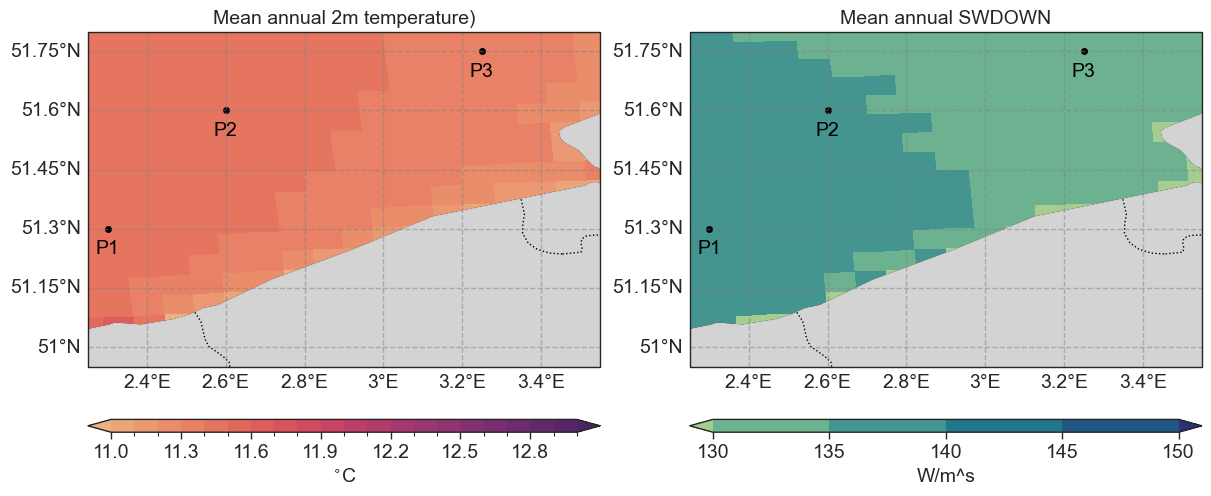

In [63]:
sns.set_theme(style="white")
sns.set_context("paper",font_scale=2)
fig = plt.figure(figsize=(12, 6), constrained_layout=True)
gs = fig.add_gridspec(1,2)
extent=[target_grids[region]['min_lon'],target_grids[region]['max_lon'],target_grids[region]['min_lat'],target_grids[region]['max_lat']]
map_plotter(gs[0,0],mean_t2m,'longitude','latitude',np.arange(11,13.1,0.1),'flare',
            f'Mean annual 2m temperature)',1,r'$^{\circ}$C','horizontal',sample_points = sample_points,extent=extent)
map_plotter(gs[0,1],mean_swdown,'longitude','latitude',np.arange(130,150.1,5),'crest',
            f'Mean annual SWDOWN',1,'W/m^s','horizontal',sample_points = sample_points,extent=extent)
plt.savefig(f'CERRA_mean_solar_resources_{region}.png',dpi=300,bbox_inches='tight',pad_inches=0)

In [64]:
%%time
regional_t2m = regional_extraction(t2m,target_grids[region]).load()
regional_swdown = regional_extraction(swdown,target_grids[region]).load()

CPU times: user 37.2 s, sys: 5.9 s, total: 43.1 s
Wall time: 1min 5s


Time elapsed for nearest point identification is 0.002582073211669922s
{'y': 7, 'x': 1}
Time elapsed for nearest point identification is 0.0011398792266845703s
{'y': 13, 'x': 5}
Time elapsed for nearest point identification is 0.0011129379272460938s
{'y': 15, 'x': 14}
Time elapsed for nearest point identification is 0.0011897087097167969s
{'y': 7, 'x': 1}
Time elapsed for nearest point identification is 0.0011589527130126953s
{'y': 13, 'x': 5}
Time elapsed for nearest point identification is 0.0011382102966308594s
{'y': 15, 'x': 14}
Time elapsed for nearest point identification is 0.0012803077697753906s
{'y': 7, 'x': 1}
Time elapsed for nearest point identification is 0.0012886524200439453s
{'y': 13, 'x': 5}
Time elapsed for nearest point identification is 0.0014503002166748047s
{'y': 15, 'x': 14}
CPU times: user 5.91 s, sys: 1.39 s, total: 7.29 s
Wall time: 4.38 s


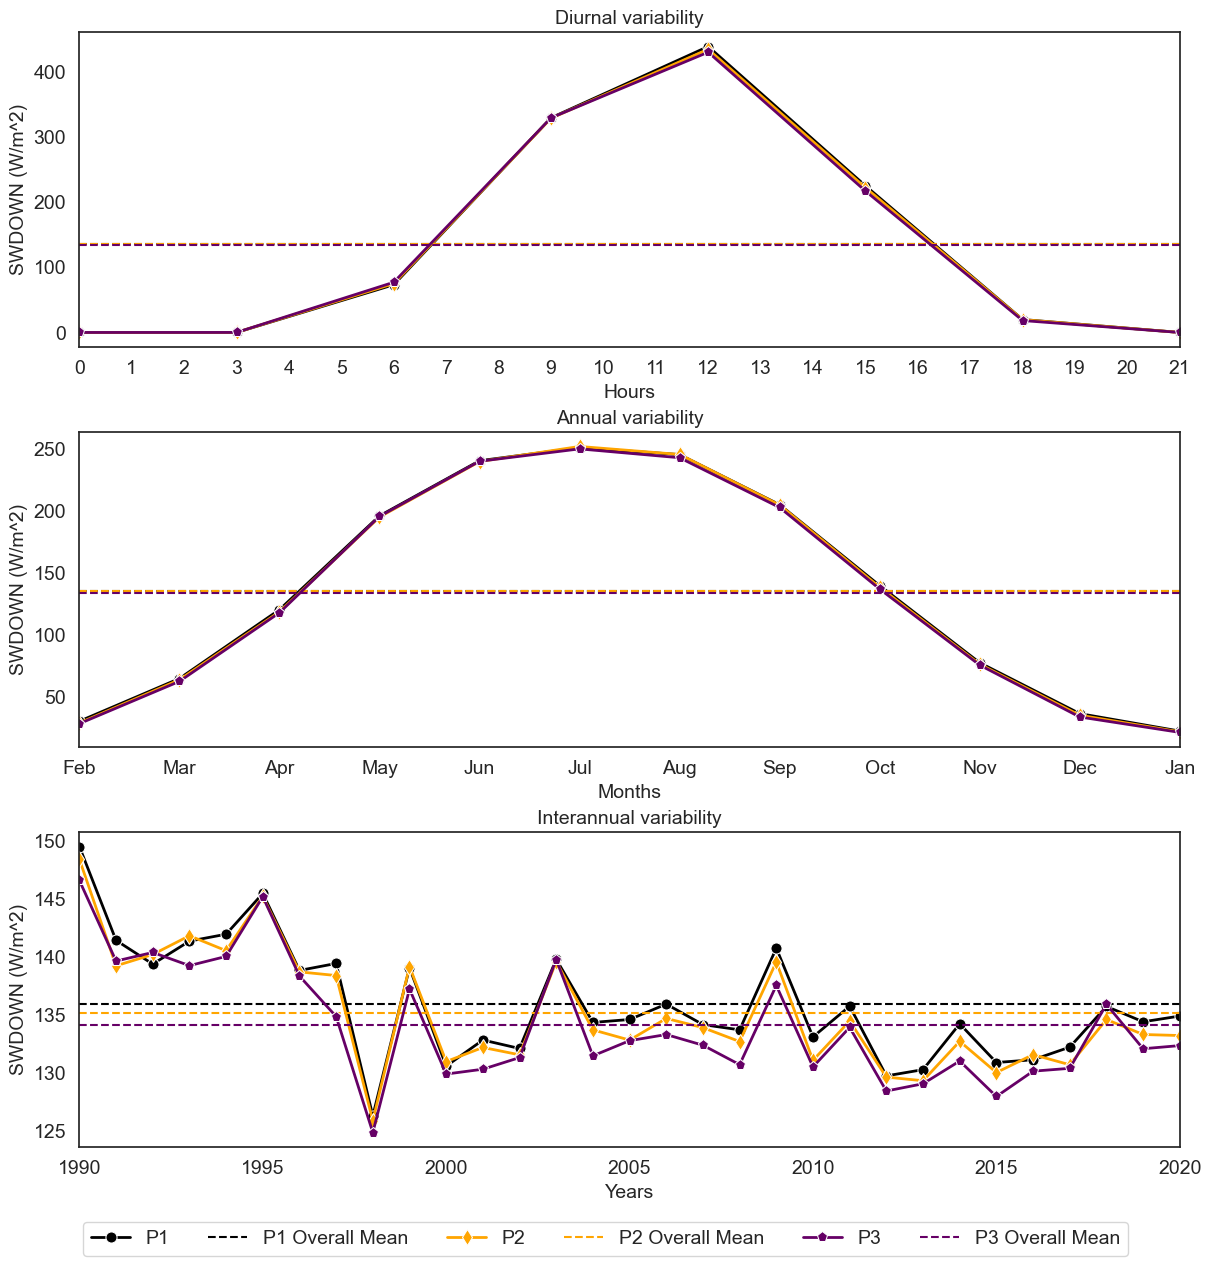

In [65]:
%%time
fig = plt.figure(figsize=(12, 12), constrained_layout=True)
gs = fig.add_gridspec(3,1)
sns.set_theme(style="white")

hourly_df = pd.DataFrame()
for i,key in enumerate(sample_points.keys()):
    ds = read_pointwise_timeseries(regional_swdown,sample_points[key][0],sample_points[key][1])

    pointwise_df = pd.DataFrame()

    # Loop through hours
    for hour in range(0,22):
        # Extract data for the current year
        data = ds.sel(time=ds.time.dt.hour == hour).mean().values
        # Create a new DataFrame with the year as a column
        #df = pd.DataFrame({'Hour': [hour], key: data})
        df = pd.DataFrame({key: data}, index=pd.Index([hour], name='Hour'))
        # Append the data to the main DataFrame
        pointwise_df = pd.concat([pointwise_df, df])
    hourly_df = pd.concat([hourly_df, pointwise_df],axis=1)

variability_plotter(gs[0,0],hourly_df,f'Diurnal variability','Hours','SWDOWN (W/m^2)', key,colors[i],'o',xlabel_ticks=hours)


monthly_df = pd.DataFrame()
for i,key in enumerate(sample_points.keys()):
    ds = read_pointwise_timeseries(regional_swdown,sample_points[key][0],sample_points[key][1])

    pointwise_df = pd.DataFrame()

    # Loop through hours
    for month in [12, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]:
        # Extract data for the current year
        data = ds.sel(time=ds.time.dt.month == month).mean().values
        # Create a new DataFrame with the year as a column
        #df = pd.DataFrame({'Hour': [hour], key: data})
        df = pd.DataFrame({key: data}, index=pd.Index([month], name='month'))
        # Append the data to the main DataFrame
        pointwise_df = pd.concat([pointwise_df, df])
    monthly_df = pd.concat([monthly_df, pointwise_df],axis=1)

variability_plotter(gs[1,0],monthly_df,f'Annual variability','Months','SWDOWN (W/m^2)', key,colors[i],'o',xlabel_ticks=months)

yearly_df = pd.DataFrame()
for i,key in enumerate(sample_points.keys()):
    ds = read_pointwise_timeseries(regional_swdown,sample_points[key][0],sample_points[key][1])

    pointwise_df = pd.DataFrame()

    # Loop through hours
    for year in list(range(1990, 2021)):
        # Extract data for the current year
        data = ds.sel(time=ds.time.dt.year == year).mean().values
        # Create a new DataFrame with the year as a column
        #df = pd.DataFrame({'Hour': [hour], key: data})
        df = pd.DataFrame({key: data}, index=pd.Index([year], name='year'))
        # Append the data to the main DataFrame
        pointwise_df = pd.concat([pointwise_df, df])
    yearly_df = pd.concat([yearly_df, pointwise_df],axis=1)

axs = variability_plotter(gs[2,0],yearly_df,f'Interannual variability','Years','SWDOWN (W/m^2)', key,colors[i],'o')

# Extract legend from one of the subplots
handles, labels = axs.get_legend_handles_labels()
# Create a common legend below the figures
fig.legend(handles, labels, loc='lower center', ncol=len(labels), bbox_to_anchor=(0.5, -0.05),fontsize=14)

plt.savefig(f'CERRA_solar_resources_variabilities_{region}.png',dpi=300,bbox_inches='tight',pad_inches=0)